In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [17]:
experiments_name = 'resnet_augmented'

In [28]:
DS_PATH = './dataset'
MODELS_PATH = './models/' + experiments_name

In [19]:
train_dir = os.path.join(DS_PATH, 'train')
test_dir = os.path.join(DS_PATH, 'TestR')
plots_dir = os.path.join('plots', experiments_name)

In [29]:
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

In [21]:
BATCH_SIZE = 32
IMG_SIZE = (32, 32)

In [22]:
class_no = 43

## Load images

In [23]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical')

Found 91441 files belonging to 43 classes.


In [24]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                           label_mode='categorical')

Found 12630 files belonging to 43 classes.


['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


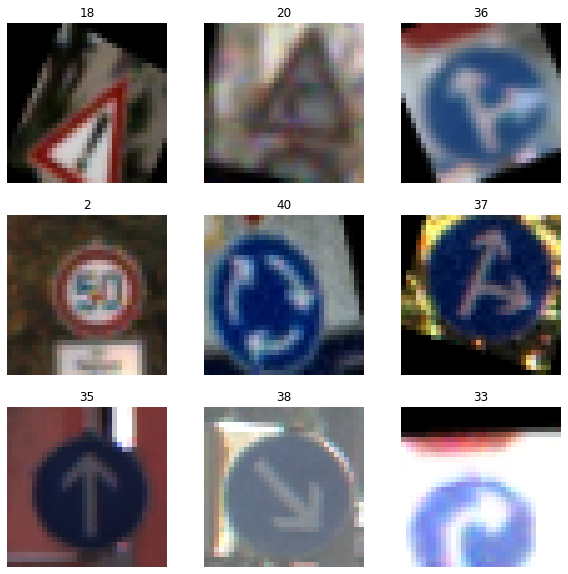

In [27]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
        
plt.savefig(plots_dir + "train_examples.png")

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 316
Number of test batches: 79


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Preprocessing for Resnet

In [13]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

## Model creation

In [14]:
# Create the base model from the pre-trained model ResNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94683136/94668760 [==============================] - 1s 0us/step


In [15]:
base_model.trainable = False

In [16]:
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()

In [17]:
prediction_layer = tf.keras.layers.Dense(class_no, activation='softmax', use_bias=True)

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x)
x = global_max_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy())

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 32, 32, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                88107 

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

316/316 [==============================] - 32s 76ms/step - loss: 3.8350 - categorical_accuracy: 0.0212


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.84
initial accuracy: 0.02


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
1226/1226 [==============================] - 242s 195ms/step - loss: 3.0646 - categorical_accuracy: 0.1668 - val_loss: 2.7949 - val_categorical_accuracy: 0.2477
Epoch 2/20
1226/1226 [==============================] - 68s 55ms/step - loss: 2.5558 - categorical_accuracy: 0.2943 - val_loss: 2.5720 - val_categorical_accuracy: 0.3072
Epoch 3/20
1226/1226 [==============================] - 67s 55ms/step - loss: 2.3422 - categorical_accuracy: 0.3467 - val_loss: 2.4477 - val_categorical_accuracy: 0.3358
Epoch 4/20
1226/1226 [==============================] - 68s 55ms/step - loss: 2.2036 - categorical_accuracy: 0.3810 - val_loss: 2.3734 - val_categorical_accuracy: 0.3469
Epoch 5/20
1226/1226 [==============================] - 67s 54ms/step - loss: 2.1023 - categorical_accuracy: 0.4040 - val_loss: 2.3264 - val_categorical_accuracy: 0.3558
Epoch 6/20
1226/1226 [==============================] - 67s 55ms/step - loss: 2.0291 - categorical_accuracy: 0.4223 - val_loss: 2.2890 - val_categor

In [25]:
model.save(MODELS_PATH + '/base_model')

INFO:tensorflow:Assets written to: ./models/base_resnet50/assets


/net/software/local/python/3.9/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [27]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

plt.savefig(plots_dirt + '/TrainingHistory')

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  190


In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy())

In [31]:
len(model.trainable_variables)

84

In [32]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
1226/1226 [==============================] - 1379s 1s/step - loss: 4.5116 - categorical_accuracy: 0.1131 - val_loss: 4.3756 - val_categorical_accuracy: 0.1518
Epoch 21/40
1226/1226 [==============================] - 1375s 1s/step - loss: 3.0212 - categorical_accuracy: 0.2019 - val_loss: 3.2481 - val_categorical_accuracy: 0.2569
Epoch 22/40
1226/1226 [==============================] - 1367s 1s/step - loss: 2.5021 - categorical_accuracy: 0.3020 - val_loss: 3.1720 - val_categorical_accuracy: 0.3297
Epoch 23/40
1226/1226 [==============================] - 1363s 1s/step - loss: 2.0858 - categorical_accuracy: 0.3949 - val_loss: 2.5237 - val_categorical_accuracy: 0.3927
Epoch 24/40
1226/1226 [==============================] - 1363s 1s/step - loss: 1.7746 - categorical_accuracy: 0.4652 - val_loss: 2.5064 - val_categorical_accuracy: 0.4369
Epoch 25/40
1226/1226 [==============================] - 1360s 1s/step - loss: 1.5321 - categorical_accuracy: 0.5324 - val_loss: 2.5932 - val_cat

In [33]:
mmodel.save(MODELS_PATH + '/fitted_model')

INFO:tensorflow:Assets written to: ./models/base_resnet50_fitted/assets


/net/software/local/python/3.9/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [34]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig(plots_dir + "fullHistory")

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

79/79 [==============================] - 3s 43ms/step - loss: 3.4242 - categorical_accuracy: 0.7033
Test accuracy : 0.7033227682113647


In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")
plt.savefig(plots_dir + "scores")

Predictions:
 [1 1 1 ... 1 1 1]
Labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
